# Ergebnisse

## Simulationsstudie

Zur Implementierung möchte ich hier unterschiedliche Implementierungen bezüglich ihrer Performanz miteinander vergleichen.
* vorgeschlagene Version via eines Zufallsvektors mit Wahrscheinlichkeiten~Uniform(0,1), der dann auf den Vektor mit Kaufwahrscheinlichkeiten gemappt wird
* direktes sampling der Produkte gemäß den Kaufwahrscheinlichkeiten

In [1]:
%matplotlib notebook

#%% PACKAGES
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
from scipy.stats import uniform

# import matplotlib as mpl
# mpl.use('module://backend_interagg')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

import time

In [2]:
#%% OVERALL PARAMETERS
numProducts = 10000
revenues = np.random.random(numProducts)*100
revenues = np.append(0, revenues)  # no purchase gives 0 revenue
products = np.arange(numProducts+1)  # product number 0 is no purchase

numPeriods = 10000

numCustomerSegments = 1
arrivalProbability = 0.8
preferenceWeights = np.random.random(numProducts)

noPurchasePreference = 0.2

capacity = 7000
offerSet = np.repeat(1, numProducts)

In [3]:
def customer_choice(preferenceWeights, noPurchasePreference, offerSet):
    ret = preferenceWeights*offerSet
    ret = np.array(ret/(noPurchasePreference + sum(ret)))
    ret = np.insert(ret, 0, 1-sum(ret))
    return ret

def sample_path(numPeriods, arrivalProbability):
    return bernoulli.rvs(size=numPeriods, p=arrivalProbability)

In [4]:
def history_rv(numPeriods, arrivalProbability, preferenceWeights, noPurchasePreference, capacity, offerSet, products, revenues):
    '''
    Over one complete booking horizon with *numPeriod* periods and a total *capacity*, the selling history is recorded. A customer comes with *arrivalProbability* and has given *preferenceWeights* and *noPurchasePreferences*.
    TODO: calculate *offerSet* over time.
    RETURN: data frame with columns (time, capacity (at start), customer arrived, product sold, revenue)
    *customerArrived*: ID of 
    *randomNumber*: to specify which product will be sold
    *customerPreferences*: for each customer segment stores the preferences to determine which product will be bought
    
    Parameters
    ----------
    customerArrived :
        the ID of the customer segment that has arrived (used for customer preferences lateron)
    '''
    index = np.arange(numPeriods+1)[::-1] # first row dummy (for for loop)
    columns = ['capacityStart', 'customerArrived', 'productSold', 'revenue', 'capacityEnd', 'randomNumber']
    
    dfHistory = pd.DataFrame(index=index, columns=columns)
    dfHistory = dfHistory.fillna(0)
    
    dfHistory.loc[numPeriods, 'capacityStart'] = dfHistory.loc[numPeriods, 'capacityEnd'] = capacity
    dfHistory.loc[(numPeriods-1):0, 'customerArrived'] = sample_path(numPeriods, arrivalProbability)
    
    dfHistory.loc[(numPeriods-1):0, 'randomNumber'] = np.random.uniform(size=numPeriods)
    
    indexCustomer = np.array([1]) # num customer segments
    columnsCustomer = products
    
    dfCustomer = pd.DataFrame(index=indexCustomer, columns=columnsCustomer)
    dfCustomer = dfCustomer.fillna(0)
    
    dfCustomer.loc[1,:] = np.cumsum(customer_choice(preferenceWeights, noPurchasePreference, offerSet))
    
    for i in np.delete(index, 0): # start in second row
        if dfHistory.loc[i,'customerArrived'] == 1:
            if dfHistory.loc[i+1, 'capacityEnd'] == 0:
                break
            
            dfHistory.loc[i,'capacityStart'] = dfHistory.loc[i+1, 'capacityEnd']
            
            prodPurchasable = (dfCustomer.loc[dfHistory.loc[i,'customerArrived'], :] < dfHistory.loc[i, 'randomNumber'])
            dfHistory.loc[i, 'productSold'] = max(prodPurchasable*products)
            
            dfHistory.loc[i,'revenue'] = revenues[dfHistory.loc[i, 'productSold']]
            
            if dfHistory.loc[i, 'productSold'] != 0:
                dfHistory.loc[i, 'capacityEnd'] = dfHistory.loc[i, 'capacityStart'] - 1
            else:
                dfHistory.loc[i, 'capacityEnd'] = dfHistory.loc[i, 'capacityStart']
        else:
            # no customer arrived
            dfHistory.loc[i,'capacityEnd'] = dfHistory.loc[i,'capacityStart'] = dfHistory.loc[i+1, 'capacityEnd']
    
    return dfHistory



In [5]:
def history_choice(numPeriods, arrivalProbability, preferenceWeights, noPurchasePreference, capacity, offerSet, products,
            revenues):
    """

    Over one complete booking horizon with *numPeriod* periods and a total *capacity*, the selling history is recorded. A customer comes with *arrivalProbability* and has given *preferenceWeights* and *noPurchasePreferences*.
    TODO: calculate *offerSet* over time.
    RETURN: data frame with columns (time, capacity (at start), customer arrived, product sold, revenue)
    *customerArrived*: ID of
    *customerPreferences*: for each customer segment stores the preferences to determine which product will be bought

    Helpers
    ----
    customerArrived :
        the ID of the customer segment that has arrived (used for customer preferences later on)

    :param numPeriods:
    :param arrivalProbability:
    :param preferenceWeights:
    :param noPurchasePreference:
    :param capacity:
    :param offerSet:
    :param products:
    :param revenues:
    :return:
    """

    index = np.arange(numPeriods + 1)[::-1]  # first row is a dummy (for nice for loop)
    columns = ['capacityStart', 'customerArrived', 'productSold', 'revenue', 'capacityEnd']

    df_history = pd.DataFrame(index=index, columns=columns)
    df_history = df_history.fillna(0)

    df_history.loc[numPeriods, 'capacityStart'] = df_history.loc[numPeriods, 'capacityEnd'] = capacity
    df_history.loc[(numPeriods - 1):0, 'customerArrived'] = sample_path(numPeriods, arrivalProbability)

    index_customer = np.array([1])  # num customer segments

    df_customer = pd.DataFrame(index=index_customer, columns=products)
    df_customer = df_customer.fillna(0)

    df_customer.loc[1, :] = customer_choice(preferenceWeights, noPurchasePreference, offerSet)

    for i in np.delete(index, 0):  # start in second row (without actually deleting row)
        if df_history.loc[i, 'customerArrived'] == 1:
            if df_history.loc[i + 1, 'capacityEnd'] == 0:
                break
            # A customer has arrived and we have capacity.

            df_history.loc[i, 'capacityStart'] = df_history.loc[i + 1, 'capacityEnd']

            df_history.loc[i, 'productSold'] = np.random.choice(products, size=1, p=df_customer.loc[1, :])

            df_history.loc[i, 'revenue'] = revenues[df_history.loc[i, 'productSold']]

            if df_history.loc[i, 'productSold'] != 0:
                df_history.loc[i, 'capacityEnd'] = df_history.loc[i, 'capacityStart'] - 1
            else:
                df_history.loc[i, 'capacityEnd'] = df_history.loc[i, 'capacityStart']
        else:
            # no customer arrived
            df_history.loc[i, 'capacityEnd'] = df_history.loc[i, 'capacityStart'] = df_history.loc[i + 1, 'capacityEnd']

    return df_history

34.369131088256836


<IPython.core.display.Javascript object>


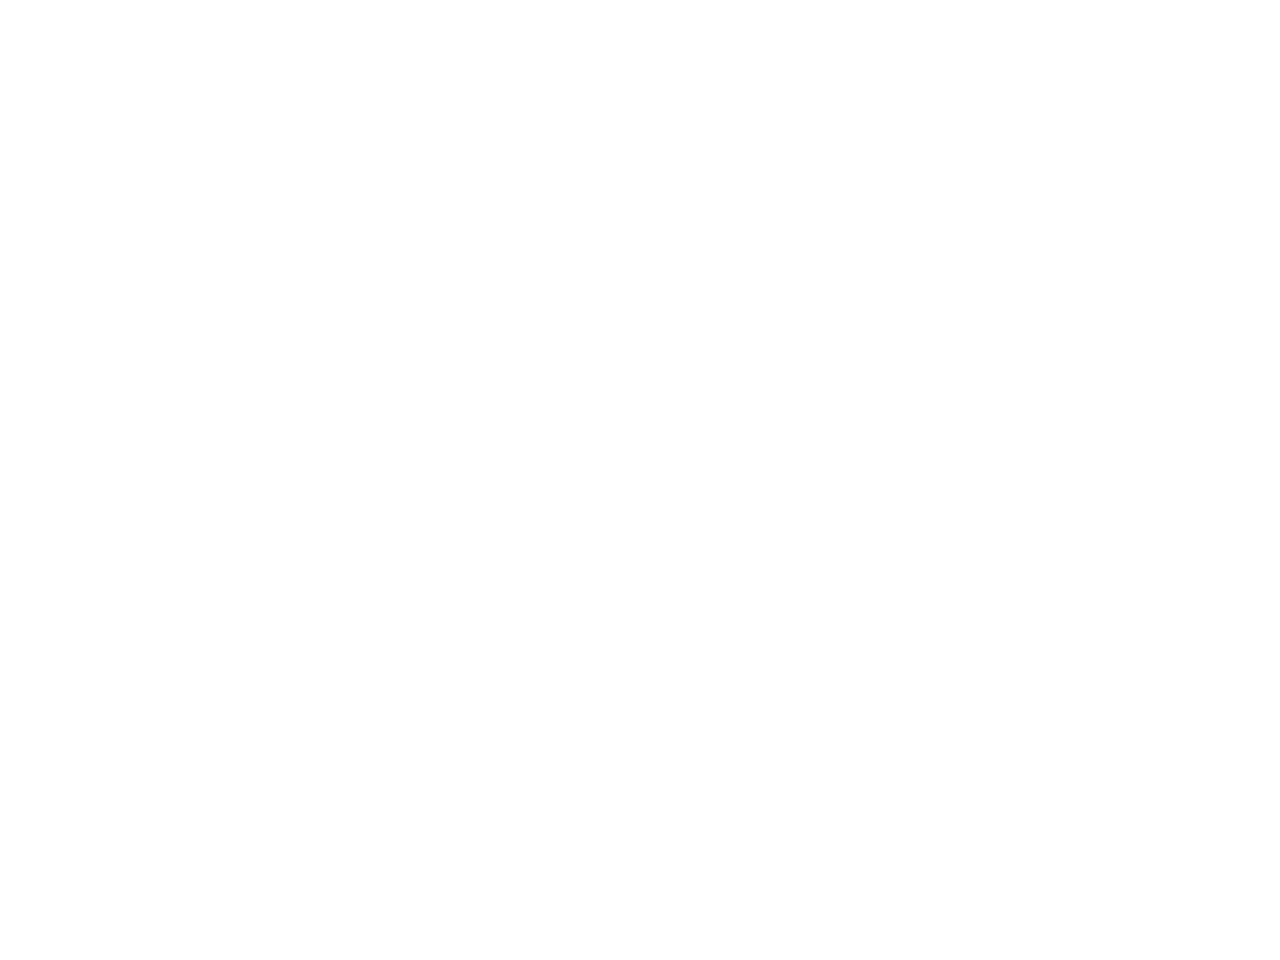

In [6]:
start_time = time.time()
dfResult = history_rv(numPeriods, arrivalProbability, preferenceWeights, noPurchasePreference, capacity, offerSet, products, revenues)
print(time.time() - start_time)

x = -dfResult.index
y = np.cumsum(dfResult['revenue'])
plt.plot(x, y)

27.95623469352722


<IPython.core.display.Javascript object>


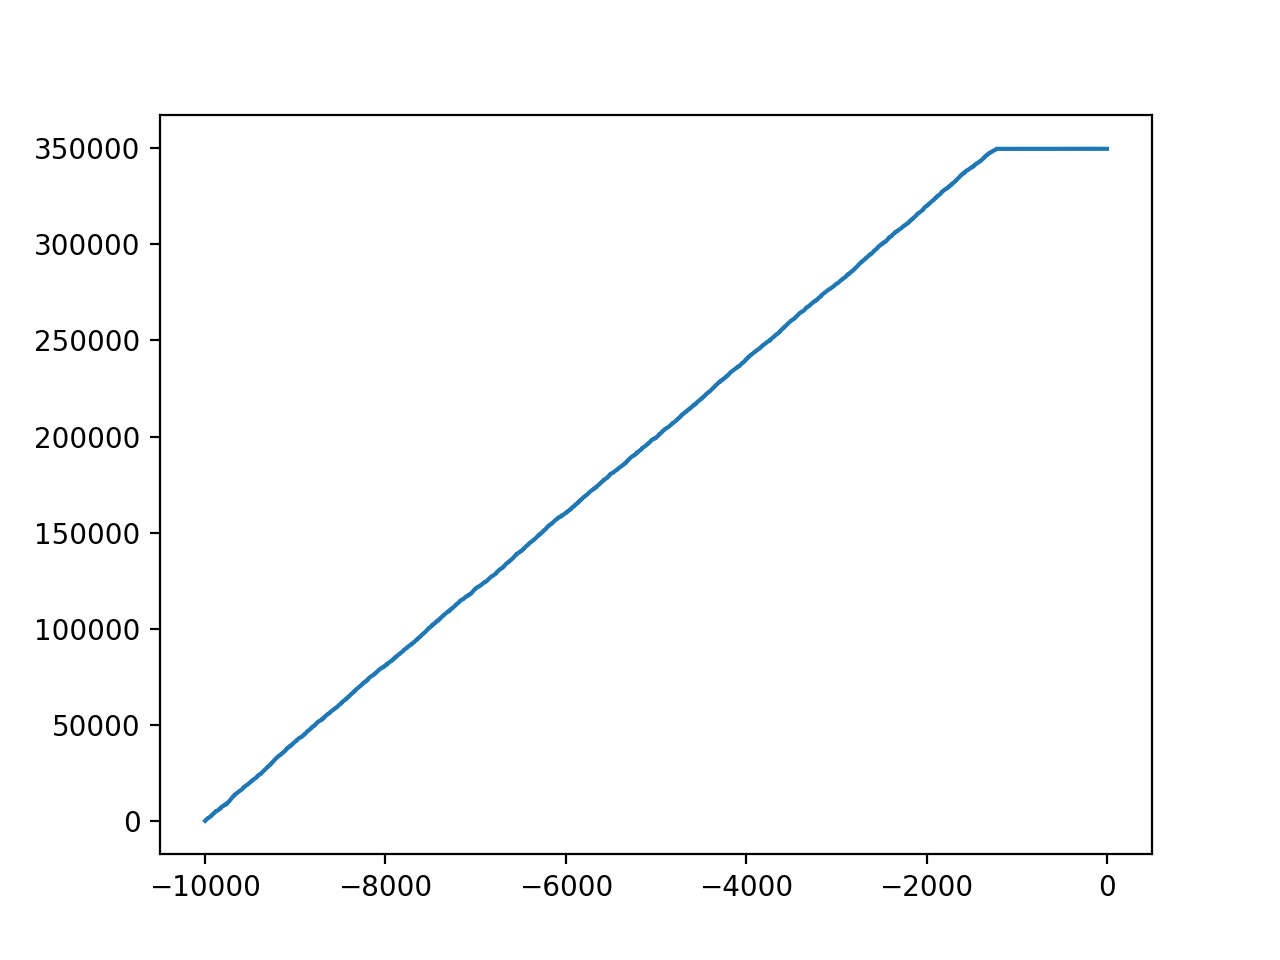

In [7]:
start_time = time.time()
dfResult = history_choice(numPeriods, arrivalProbability, preferenceWeights, noPurchasePreference, capacity, offerSet, products, revenues)
print(time.time()-start_time)

x = -dfResult.index
y = np.cumsum(dfResult['revenue'])
plt.close()
plt.plot(x, y)